## This notebook is the solution for Question 1 in he Olive Diagnostic home Assignmnet

### Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from typing import Dict, Any
import itertools

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

### Uploading the ata

In [ ]:
data = pd.read_csv('data_for_classification.csv')
data.head(10)

,Patient_ID,Protein,pH,Specific_Gravity,Blood,Age,Gender,Glucose,Calcium,Condition
0,1,0.549671,6.463089,1.026997,0,64,Male,81.913568,9.099271,1
1,2,0.486174,6.954708,1.024623,0,51,Female,97.284908,9.665405,1
2,3,0.564769,5.300716,1.020298,0,67,Female,95.883400,9.347795,0
3,4,NaN,6.281485,1.016765,0,41,Female,NaN,9.621079,0
4,5,0.476585,5.674679,1.023491,0,23,Female,96.926143,9.143055,0
5,6,0.476586,5.756437,1.021967,0,24,Male,98.981833,10.345089,0
6,7,0.657921,5.703803,1.024476,0,56,Female,NaN,9.962699,1
7,8,NaN,5.568005,1.023176,0,60,Male,83.292204,9.515891,0
8,9,0.453053,6.024261,1.025248,0,68,Female,111.060597,10.364557,0
9,10,0.554256,5.584525,1.017324,0,32,Male,117.116991,9.537140,0


In [ ]:
data['Patient_ID'].value_counts().values.all() == 1

True

Patient_ID is an oridnall feature, with no computing value, therefore it can be discraded

In [ ]:
data.drop('Patient_ID', axis=1, inplace=True)
data.head(10)

,Protein,pH,Specific_Gravity,Blood,Age,Gender,Glucose,Calcium,Condition
0,0.549671,6.463089,1.026997,0,64,Male,81.913568,9.099271,1
1,0.486174,6.954708,1.024623,0,51,Female,97.284908,9.665405,1
2,0.564769,5.300716,1.020298,0,67,Female,95.883400,9.347795,0
3,NaN,6.281485,1.016765,0,41,Female,NaN,9.621079,0
4,0.476585,5.674679,1.023491,0,23,Female,96.926143,9.143055,0
5,0.476586,5.756437,1.021967,0,24,Male,98.981833,10.345089,0
6,0.657921,5.703803,1.024476,0,56,Female,NaN,9.962699,1
7,NaN,5.568005,1.023176,0,60,Male,83.292204,9.515891,0
8,0.453053,6.024261,1.025248,0,68,Female,111.060597,10.364557,0
9,0.554256,5.584525,1.017324,0,32,Male,117.116991,9.537140,0


### Parameters

In [26]:
features = data.columns[:-1] # no need to compute for Patient_ID
label = 'Condition'
categorical_features = ['Gender', 'Blood']
continous_features = features.difference(categorical_features)

mapper = {
    'Male': 1,
    'Female': 0
    }

### Data Handeling

#### Checking for Imbalencing

In [ ]:
def plot_pie_chart(
    data: pd.DataFrame,
    feature: str = label,
    ):
  """
  plot pie chart for a given feature
  Parameters:
  - data (pd.DataFrame): The input DataFrame containing patient urine analysis results and labels.
  - feature (str): The name of the column indicating the presence or absence of the medical condition.
  """
  feature_value_counts = data[feature].value_counts()
  feature_value_counts.plot(kind='pie', autopct='%1.1f%%')
  plt.title(f'Distribution of {feature}')
  plt.ylabel('')
  plt.show()

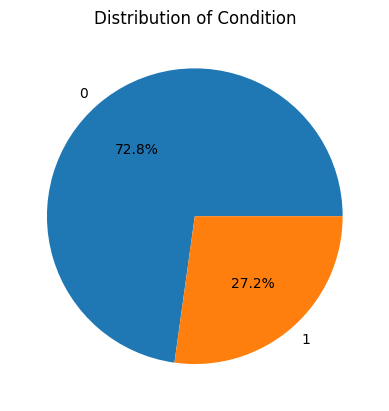

In [ ]:
plot_pie_chart(data)

The label is imbalanced, there is significantly higher number of not-healthy indivisuals. I will handle it later on

#### Checking for features types

There are outliers in some features - protein, pH, Specific_Gravity, Glucose, and Calcium.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Protein           450 non-null    float64
 1   pH                450 non-null    float64
 2   Specific_Gravity  450 non-null    float64
 3   Blood             500 non-null    int64  
 4   Age               500 non-null    int64  
 5   Gender            500 non-null    object 
 6   Glucose           450 non-null    float64
 7   Calcium           500 non-null    float64
 8   Condition         500 non-null    int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 35.3+ KB


There are 9 numeric features, and 1 categorical - 'Gender'. We should map it to numeric values

As can be seen, 'Gender' has to classes- Male and Female
the simplest way to encode to numeric values it is to map it to corresponding numeric values, such as 1 and 0. This maaping actions is simple beacuse this feature has only two classes, and it is not the predicted label (that would be 'Condition')

In [ ]:
data['Gender'] = data['Gender'].map(mapper)

data.head(10)

,Protein,pH,Specific_Gravity,Blood,Age,Gender,Glucose,Calcium,Condition
0,0.549671,6.463089,1.026997,0,64,1,81.913568,9.099271,1
1,0.486174,6.954708,1.024623,0,51,0,97.284908,9.665405,1
2,0.564769,5.300716,1.020298,0,67,0,95.883400,9.347795,0
3,NaN,6.281485,1.016765,0,41,0,NaN,9.621079,0
4,0.476585,5.674679,1.023491,0,23,0,96.926143,9.143055,0
5,0.476586,5.756437,1.021967,0,24,1,98.981833,10.345089,0
6,0.657921,5.703803,1.024476,0,56,0,NaN,9.962699,1
7,NaN,5.568005,1.023176,0,60,1,83.292204,9.515891,0
8,0.453053,6.024261,1.025248,0,68,0,111.060597,10.364557,0
9,0.554256,5.584525,1.017324,0,32,1,117.116991,9.537140,0


#### Handeling NaN values

Handleing NaN values approaches are vary between discrad the rows and applying different mathematical techniques such as putting the mean or the meidan value of all the other values, in order to preserve the values scale. First, I think that there is no reason to discard these NaN values, and by looking on the features with NaN values, it can be seen that all of them are continus numeric. Therefore, I think that the right decision is to fill them the median value, because it less sensitive for outliers.

In [ ]:
data.isnull().sum()

,0
Protein,50
pH,50
Specific_Gravity,50
Blood,0
Age,0
Gender,0
Glucose,50
Calcium,0
Condition,0


There are some NaN values

Putting the median value

In [ ]:
nan_columns = data.columns[data.isna().any()].tolist() # taking only columns with NaN values

for column in nan_columns:
    data[column].fillna(data[column].median(), inplace=True)

print(data.isnull().sum()) # Checking action worked
print()
print(data.info())

Protein             0
pH                  0
Specific_Gravity    0
Blood               0
Age                 0
Gender              0
Glucose             0
Calcium             0
Condition           0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Protein           500 non-null    float64
 1   pH                500 non-null    float64
 2   Specific_Gravity  500 non-null    float64
 3   Blood             500 non-null    int64  
 4   Age               500 non-null    int64  
 5   Gender            500 non-null    int64  
 6   Glucose           500 non-null    float64
 7   Calcium           500 non-null    float64
 8   Condition         500 non-null    int64  
dtypes: float64(5), int64(4)
memory usage: 35.3 KB
None


#### Checking for outliers

Please note that in this section, I will only identify whether there are outliers for each continuous feature. The process of handling them will be conducted later.



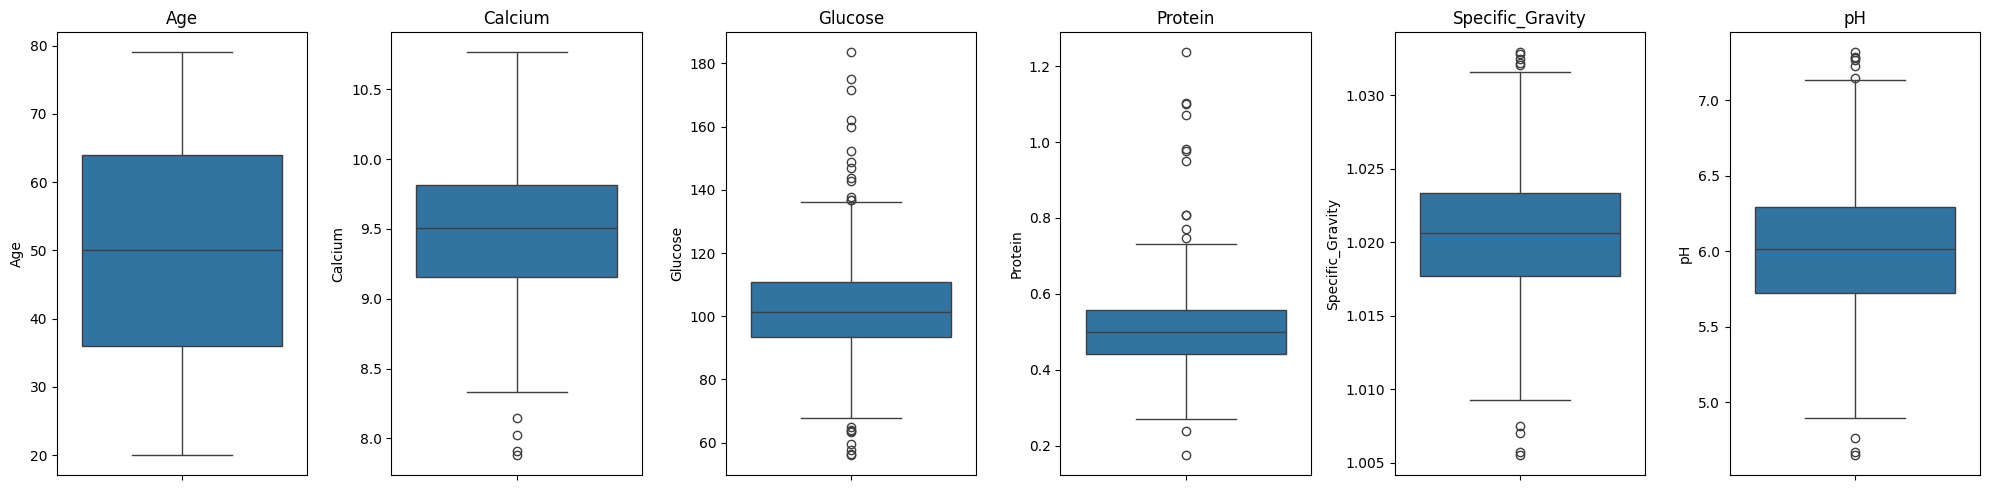

In [28]:
fig, axes = plt.subplots(1, 6, figsize=(20, 5))

for i, feature in enumerate(continous_features):
    sns.boxplot(y=data[feature], ax=axes[i])
    axes[i].set_title(feature)

plt.tight_layout()
plt.show()

There are few common methods for checking for outliers, the most two common are Z-Scores for nurmal distributed data, and IQR for non-normal distributed. This combined approach allows to leverage the strengths of each method, ensuring that outlier detection is both accurate and appropriate for the nature of the data.

* Age: There are no apparent outliers.
* Calcium: A few outliers are present on the lower end, indicating lower calcium levels.
* Glucose: Glucose levels show a skewed distribution with several outliers. These outliers suggest that some individuals have significantly higher or lower glucose levels, which might indicate conditions like diabetes.
* Protein: Protein levels show a skewed distribution with several outliers. as in GLucose, higher or lower values may indicate health problems.
* Specific_Gravity: The specific gravity of urine shows some outliers on both the lower and higher ends.
* pH: The pH distribution shows outliers on both the lower and higher ends, indicating some variation in urine acidity.

### EDA

#### Feautres Distribution by Conditions

In [29]:
def plot_feature_distribution_by_condition(
    data : pd.DataFrame,
    features : list = features,
    label : str = label
    ):
    """
    Grouping data by 'Condition' and plotting the distribution of each feature

    Parameters:
    - data (pd.DataFrame): The input DataFrame containing patient urine analysis results and labels.
    - features (list): List of feature names to plot.
    """

    num_features = len(features)
    plt.figure(figsize=(15, num_features * 4))

    for i, feature in enumerate(features):
        plt.subplot(num_features, 1, i + 1)

        grouped_data = data.groupby(label)[feature]

        sns.kdeplot(data=data, x=feature, hue=label, fill=True, common_norm=False, alpha=0.5)

        plt.title(f'Distribution of {feature} by Condition')
        plt.xlabel(feature)
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

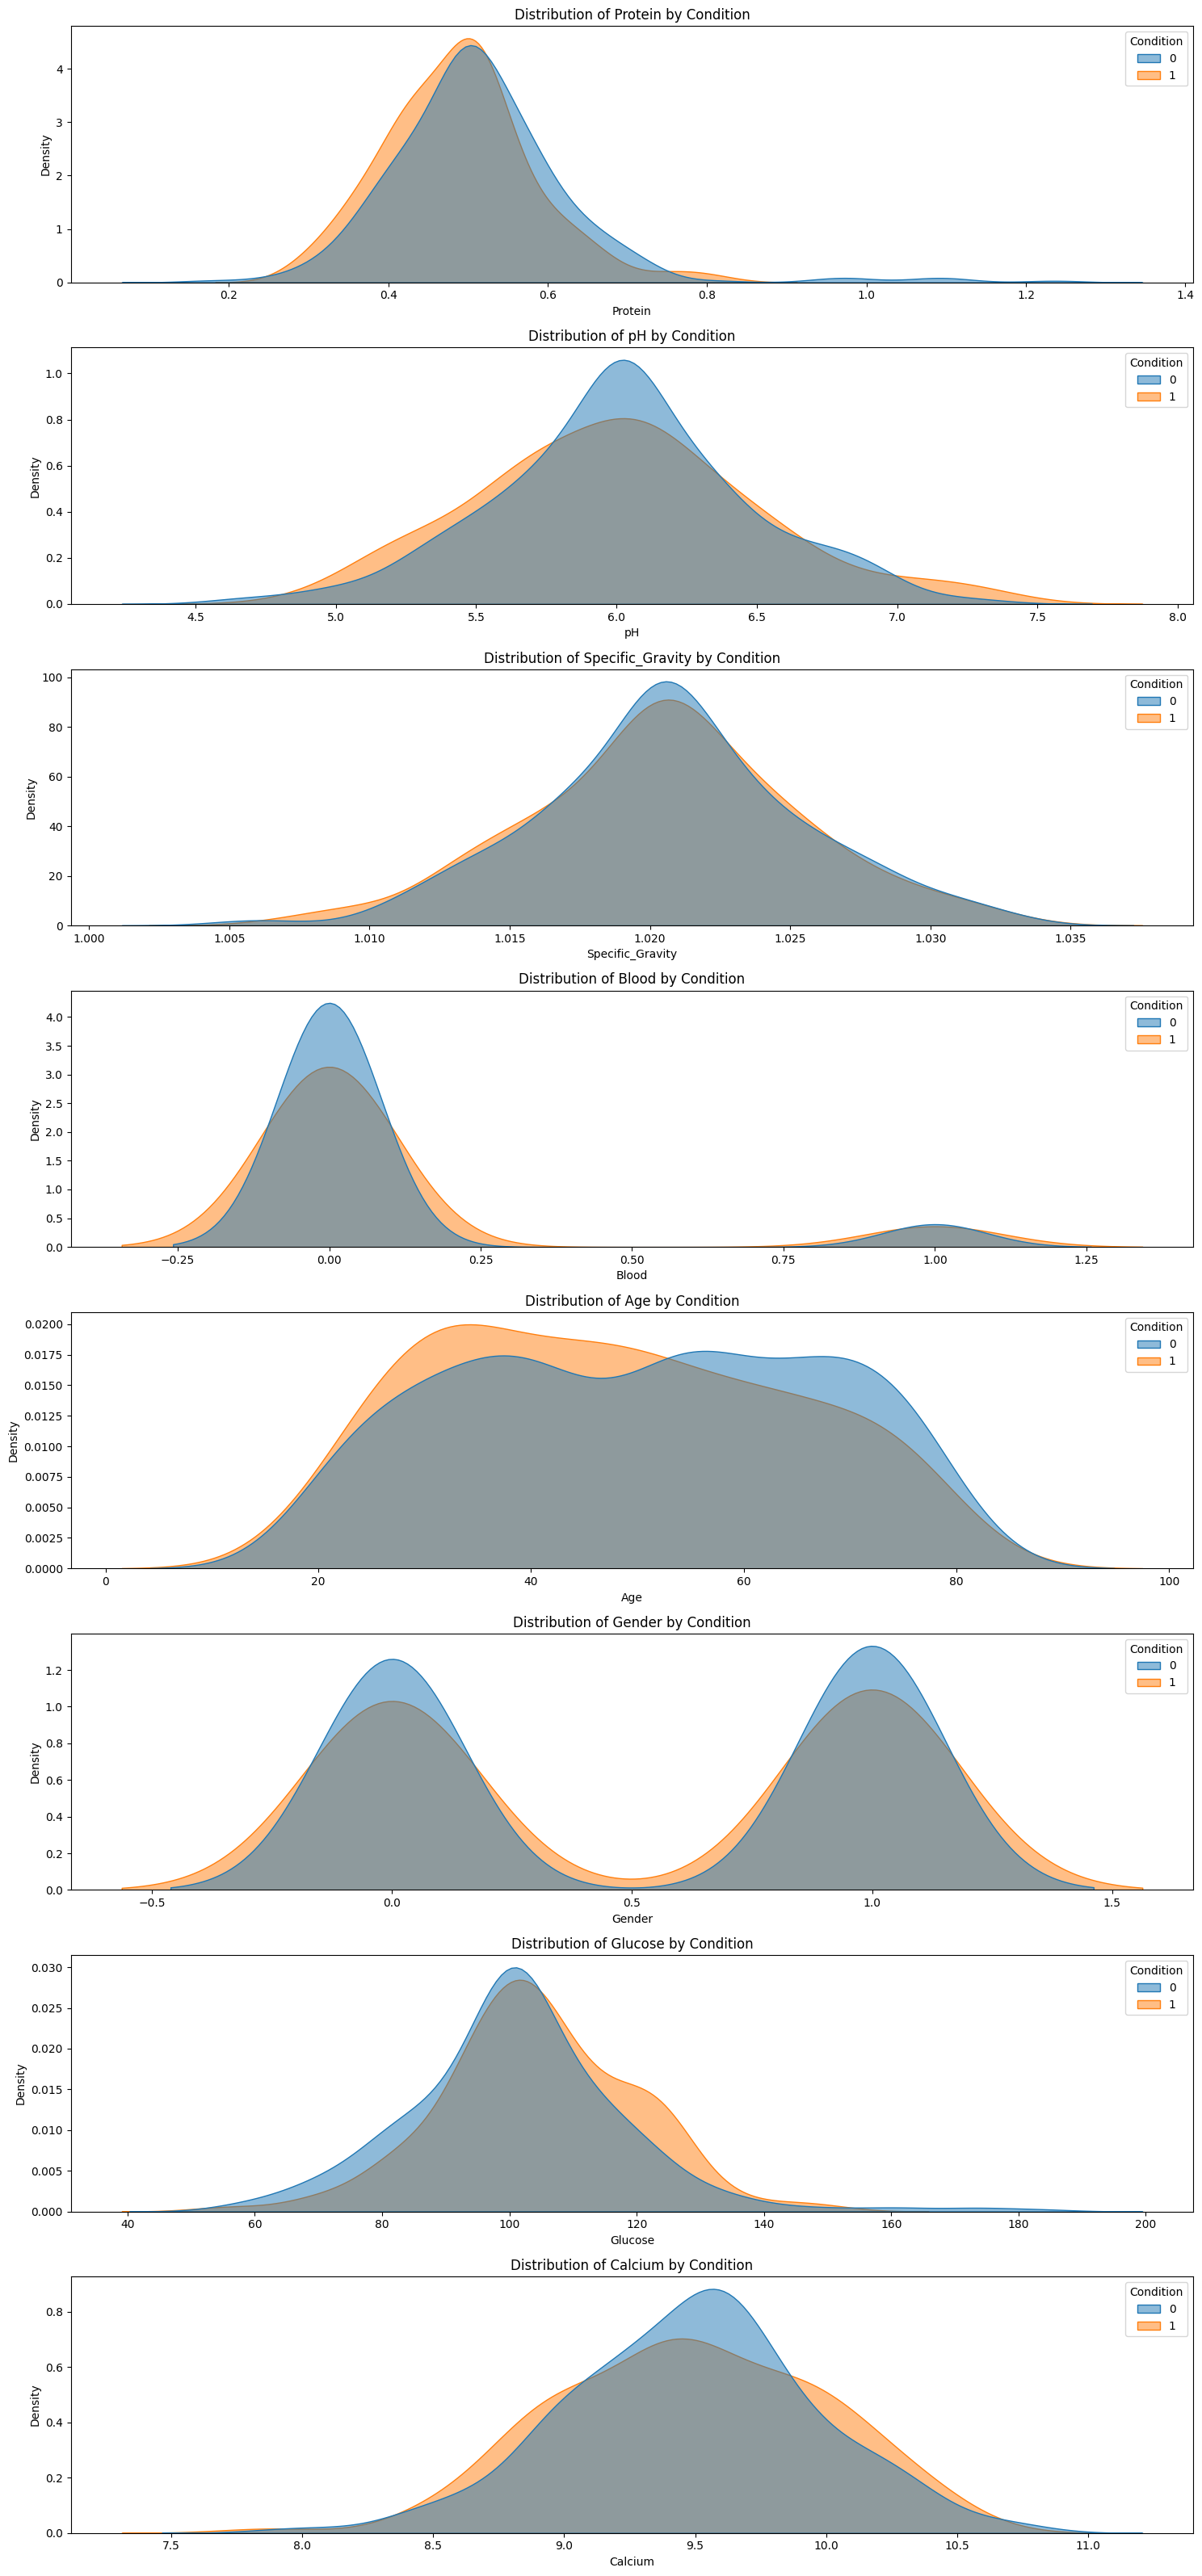

In [30]:
plot_feature_distribution_by_condition(data)

Observations:

* Protein: The distribution shows that healthier individuals tend to have slightly higher protein levels, peaking around 0.5. In contrast, not-healthy individuals show a broader distribution that slightly shifts towards lower protein values. This could imply that protein levels might be associated with health issues.

* pH: Healthy individuals tend to have a pH distribution more centered around 6.0, whereas the not-healthy group has a slightly broader distribution towards the acidic side (around 5.5). This could suggest that maintaining a neutral to slightly basic pH might be associated with better health.

* Specific Gravity: Both conditions show a very similar distribution with peaks around 1.020, suggesting that specific gravity may not be a strong indicator of health status in this dataset. This could imply that hydration levels (often reflected by specific gravity) are relatively consistent across both healthy and not-healthy individuals.

* Blood: The blood distribution shows that healthier individuals have a higher concentration around the zero mark, implying fewer blood abnormalities. In contrast, not-healthy individuals show a wider distribution, which might indicate that blood eceptions (like the presence of blood in urine) could be more common among not-healthy individuals.

* Age: The age distribution indicates that healthier individuals are relatively evenly distributed across various age groups, while not-healthy individuals tend to peak around the age of 60. This suggests that the likelihood of health issues might increase with age, highlighting age as a potential risk factor.

* Gender: The distribution indicates that health status varies between genders. Not-healthy individuals show a higher density among females, while healthy individuals show a higher density among males. This suggests that females may be more likely to be classified as not-healthy compared to males.

* Glucose: Healthier individuals show a peak around 100, while not-healthy individuals have a broader distribution that stretches towards higher glucose levels. This indicates that high glucose levels might be associated with not-healthy conditions, suggesting a link to conditions such as diabetes or metabolic syndromes.

* Calcium: The distribution for calcium shows that healthy individuals have a slightly higher peak around 9.5 compared to not-healthy individuals. This suggests that calcium levels are somewhat consistent between both groups, but higher calcium may still have a slight association with better health.

#### Correlation Matrix

In [31]:
def plot_correlation_matrix(
    data : pd.DataFrame,
    features : list = features,
    label : str = label
    ):
  """
  Plot a correlation matrix for the specified features.

  Parameters:
  - data (pd.DataFrame): The input DataFrame containing patient urine analysis results and labels.
  - features (list): List of feature names to include in the correlation matrix.
  """
  correlations = data[features].corrwith(data[label]).sort_values(ascending=False)

  plt.figure(figsize=(10, 8))
  sns.heatmap(correlations.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
  plt.title(f'Correlation with {label}')
  plt.show()

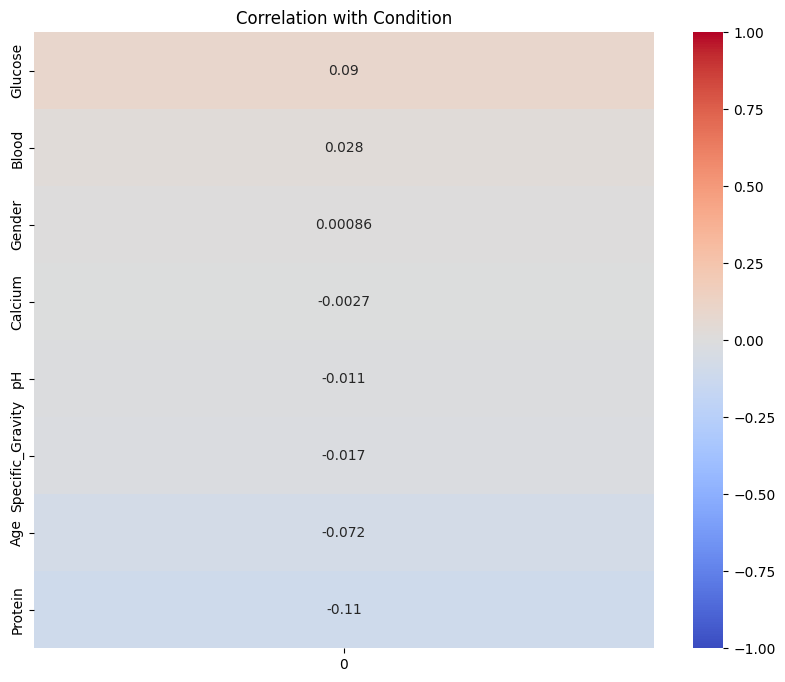

In [32]:
plot_correlation_matrix(data)

Observations:

* Glucose: Has a positive correlation of 0.09 with the condition. This suggests that higher glucose levels are somewhat associated with the presence of the condition.
* Blood: Has a small positive correlation of 0.028.

* Gender: Has a very slight positive correlation of 0.00086, indicating almost no correlation with the condition.

* Calcium: Has a negligible negative correlation of -0.0027.

* pH: Shows a small negative correlation of -0.011.

* Age: Has a negative correlation of -0.017.

* Specific Gravity: Shows a moderate negative correlation of -0.072.

* Protein: Has a negative correlation of -0.11, similar in magnitude to the positive correlation observed with glucose.

Overall, Glucose and Protein show the strongest correlations with the condition, though neither is particularly strong. This might suggest that while they are the most relevant features, they are not crucial factors of the condition on their own.

### Model Building

#### Preparing the Data for ML Models

#### Scaling and Handeling Ourliers

In the data, Features like Age, Glucose, and Specific_Gravity have different ranges and units. Without scaling, these differences can lead to features with larger ranges having more influence on the model.

Therefore, I decided to scale continous features, and leave discrite and categorical as is.

Because of the outliers in the dataset, I decided to use RobutSCaler, which is able to handle outliers using statistical meethods robust to outleirs.

In [ ]:
X = data.drop(label, axis=1)
y = data[label]

scaler = RobustScaler()
scaled_features = scaler.fit_transform(X[continous_features])

scaled_df = pd.DataFrame(scaled_features, columns=continous_features, index=X.index)
X[continous_features] = scaled_df

X

,Protein,pH,Specific_Gravity,Blood,Age,Gender,Glucose,Calcium
0,0.549671,0.788340,1.126904,0,0.500000,1,-1.128991,-0.617070
1,0.486174,1.652338,0.708815,0,0.035714,0,-0.238955,0.240233
2,0.564769,-1.254473,-0.052997,0,0.607143,0,-0.320106,-0.240727
3,0.500912,0.469180,-0.675273,0,-0.321429,0,0.000000,0.173109
4,0.476585,-0.597252,0.509414,0,-0.964286,0,-0.259728,-0.550768
...,...,...,...,...,...,...,...,...
495,0.553891,-0.272526,1.661260,0,-0.392857,1,-0.387517,0.137789
496,0.396275,1.554158,1.710060,1,0.857143,1,1.747246,-0.810598
497,0.480966,0.537609,0.958699,0,-0.107143,0,-0.423184,-0.737713
498,0.412438,-0.527425,0.796382,1,-0.535714,1,1.518662,0.499026


#### Over Sampeling and Train Test Split

AS shown before, the label distribution is imbalanced. In order to resolve that, I will create new data samples for the minority class - not-healthy people (1), I will use the SMOTE algorithm.

SMOTE uses KNN in the background to create a bew data samples that close to the other class samples.

After balancing, the next step is train-test split

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(y_resampled.value_counts())

Condition
1    364
0    364
Name: count, dtype: int64


Clearly, the data set is now balanced

### Modeling

#### Model Building

One of the important steps in model building is finding the best hyperparameters and the feaures with the highest contributin to the model perforamnce.

I decided to work with GreadSearchCV for hyperparamter selection, and REF for feature selection. The combination of these techniques results in the best model hyperparameters alongside the number and names of the most important features.


Parameters

In [ ]:
param_grid = {
    'feature_selection__n_features_to_select': range(1, X.shape[1] + 1), # For feature selection
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__criterion': ['gini', 'entropy']
}

Train-Test Split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.3)

print(f"X_train shape: {x_train.shape}")
print(f"X_test shape: {x_test.shape}")

X_train shape: (509, 8)
X_test shape: (219, 8)


Hyperparameters and feature importance

In [ ]:
model = RandomForestClassifier()
rfe = RFE(estimator=model)

pipeline = Pipeline([
    ('feature_selection', rfe),
    ('model', model)
])

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_selection',
                                        RFE(estimator=RandomForestClassifier())),
                                       ('model', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'feature_selection__n_features_to_select': range(1, 9),
                         'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [None, 10, 20, 30],
                         'model__n_estimators': [50, 100, 200]},
             verbose=2)

In [ ]:
best_n_features = grid_search.best_params_['feature_selection__n_features_to_select']
print(f'Optimal number of features: {best_n_features}')

rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=best_n_features)

X_selected = rfe.fit_transform(X_resampled, y_resampled)

selected_features = X.columns[rfe.support_]
print(f'Selected features: {selected_features}')

Optimal number of features: 7
Selected features: Index(['Protein', 'pH', 'Specific_Gravity', 'Age', 'Gender', 'Glucose',
       'Calcium'],
      dtype='object')


In [ ]:
features.difference(selected_features)

Index(['Blood'], dtype='object')

As can be clearly seen, that REF discraded 'Blood', that would indicate that this feature has low effect on the condition. This can be seen in the EDA part, where the plot of the distribution of blood tends to 0, meaning most of the patients did not have blood in the urine, heatlyh and not-healthy as one, which may indicate that it is indeed not a conclusive indicator.

Creating new Train-Test split according to selected features

In [ ]:
new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(
    X_selected, y_resampled, test_size=0.3, random_state=42)

print(f"new_x_train shape: {new_x_train.shape}")
print(f"new_x_val shape: {new_x_test.shape}")

new_x_train shape: (509, 7)
new_x_val shape: (219, 7)


##### Building RandomForestClassifier with the Best Parameters

In [ ]:
_ = grid_search.best_params_.pop('feature_selection__n_features_to_select')
best_params = grid_search.best_params_
print(best_params)

params = {k.replace('model__', ''): v for k, v in best_params.items()} # Removing prefix
best_rf_model = RandomForestClassifier(**params)

{'model__criterion': 'gini', 'model__max_depth': None, 'model__n_estimators': 50}


#### Training and evaluation

##### Performing cross validation to estimate the true performance of the model

In [ ]:
def cross_validate_model(model, X, y, cv=5, score='f1'):
  """
  Compute cross validation scores for a given model.
  Parameters:
  - model: The machine learning model to be evaluated.
  - X: The feature matrix.
  - y: The target variable.
  - cv: The number of cross-validation folds (default is 5).
  - score: The evaluation metric (default is 'f1').
  """
  cv_scores = cross_val_score(model, X, y, cv=cv, scoring=score)

  print("Cross-validation scores:", cv_scores)
  print("Mean cross-validation score:", cv_scores.mean())

In [ ]:
cross_validate_model(best_rf_model, new_x_train, new_y_train)

Cross-validation scores: [0.60377358 0.63265306 0.74468085 0.59615385 0.77083333]
Mean cross-validation score: 0.669618935336232


Cross validation mean score isn't very high, meaning the model performance are unsatisfactory as expected. This might happen because of model selection, or lack of feature engineering. As seen in the correlation matrix, all features have low correlation with the label.

##### Model evaluation

In [ ]:
best_rf_model.fit(new_x_train, new_y_train)
y_pred = best_rf_model.predict(new_x_test)

print(classification_report(new_y_test, y_pred))
print(confusion_matrix(new_y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.66      0.67       110
           1       0.67      0.69      0.68       109

    accuracy                           0.68       219
   macro avg       0.68      0.68      0.68       219
weighted avg       0.68      0.68      0.68       219

[[73 37]
 [34 75]]


##### Plot ROC-Curve

ROC courve is used to find the optimal classification threshold.

In [ ]:
def plot_roc_curve(model, X_test, y_test):
  """
  Compute and plot roc curve for a given model
  Parameters:
  - model: The machine learning model to be evaluated.
  - X_test: The test feature matrix.
  - y_test: The test target variable.
  """
  y_prob = model.predict_proba(new_x_test)[:, 1]

  fpr, tpr, thresholds = roc_curve(new_y_test, y_prob)

  roc_auc = auc(fpr, tpr)
  print(f'ROC AUC: {roc_auc:.2f}')
  print()

  # Plot ROC curve
  plt.figure(figsize=(10, 6))
  plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC)')
  plt.legend(loc='lower right')
  plt.show()

  # Determine the optimal threshold
  print()
  optimal_idx = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal_idx]
  print(f'Optimal Threshold: {optimal_threshold:.2f}')

  return optimal_threshold, y_prob

ROC AUC: 0.76



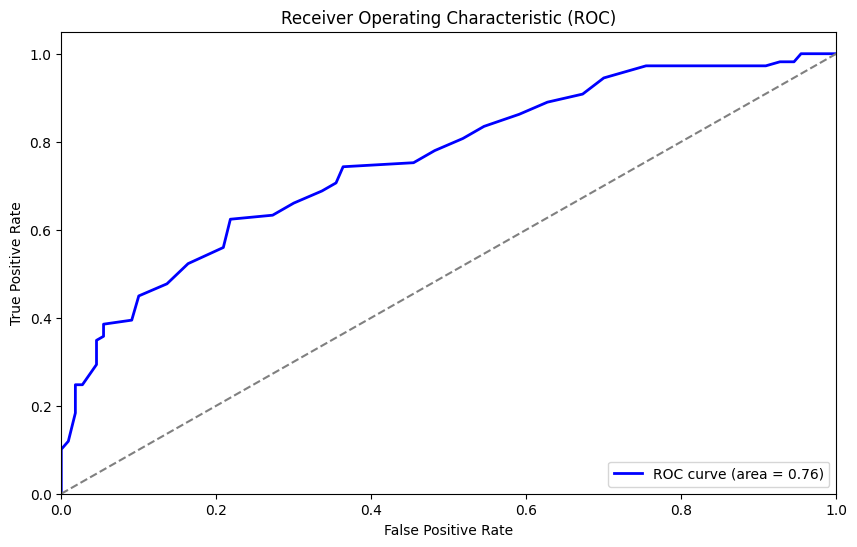


Optimal Threshold: 0.58


In [ ]:
threshold, y_prob = plot_roc_curve(best_rf_model, new_x_test, new_y_test)

In [ ]:
y_pred = (y_prob >= threshold).astype(int)

print(classification_report(new_y_test, y_pred))

print(confusion_matrix(new_y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.78      0.73       110
           1       0.74      0.62      0.68       109

    accuracy                           0.70       219
   macro avg       0.71      0.70      0.70       219
weighted avg       0.71      0.70      0.70       219

[[86 24]
 [41 68]]


As expected, using the optimal thershold the preforamnce increased a little.

## Analysis of Model Performance


The model, built using a RandomForestClassifier with selected features, yielded moderate performance as can be seen from the cross-validation scores and the cmetrics values for the test set. Despite the careful selection of hyperparameters and feature importance, the model's mean cross-validation score was unsatisfactory, even after applying threshold.

**Limitations:**

* Imbalanced Data: Despite using SMOTE to balance the data, the initiall class imbalance might still affect the model's performance. SMOTE only synthetically balances the data, and real-world complexities of the minority class might not be fully captured.

* Feature Engineering: The features used in the model, though selected via RFE, showed weak correlations with the target. This suggests that additional feature engineering or the inclusion of more relevant features might be necessary to improve model performance.

* Outliers handeling: handeling outliers has two main approaches- discard the outliers, and keep them while performing actions to reduce their effect. However, in medical data, outliers can provide a crucial diagnostic information. For example, high glucose might indicate diabetes. Therefore it might not be a good idea to touch them at all.

* Model Selection: The use of RandomForestClassifier, though it's advantages, might not be the best choice for this dataset. Other models, could potentially yield better results.

**Improvments**

* Feature Engineering: The weak correlations suggest that additional feature engineering might be needed. This could involve creating new features or transforming existing ones to better capture the underlying patterns in the data.

* Using different balancing approaches: SMOTE is not necessarily suitable for all data sets, because it might create data samples that are not possible. For example, if ‘Gender’ is encoded as 1 and 0 for male and female, as I did. SMOTE might produce a sample with ‘Gender’ of 0.5 which does not make any sense. Therefore, different balancing techniques may be taken into consideration. Honestly, I was thinking about this improvement after reading a post on Linkedin that presents an article that proves that, a few hours before the deadline.

* Model Selection: The Random Forest classifier was used in this case, but exploring other models, might yield better results. These models could potentially capture more complex relationships in the data.

**Implications of Findings**

The results suggest that, while the current model works, it may not be reliable enough for clinical use without further improvements. The errors, especially in telling apart healthy and non-healthy individuals, could have serious consequences in a real-world context. Therefore, more research, including advanced modeling techniques and further exploration of features, is necessary to develop a more accurate predictive tool.

**Error Analysis**

* Confusion Matrix: The confusion matrix shows a significant number of false positives and false negatives, indicating that the model has difficulty accurately identifying both healthy and non-healthy individuals.

* ROC Curve and AUC: The ROC curve displayed a moderate area under the curve , which suggests that the model has some ability to distinguish between classes, but it's not very strong. Adjusting the threshold slightly improved performance, but not by much.

* Feature Importance: The feature selection process using RFE highlighted certain features as more important. However, the EDA and correlation matrix showed that no single feature was strongly correlated with the condition, which may have limited the model's ability to predict outcomes accurately.

**Rejecting Predictions and Its Impact**

If there was an option to reject some predictions (for instance, those with low confidence), the criterion could be based on the predicted probability. For example, predictions with probabilities close to 0.5 (indicating uncertainty) could be rejected. By doing this, the model would only make predictions when it is more confident, potentially improving precision but at the cost of lower recall. This trade-off could be shown by plotting the precision-recall curve or adjusting the classification threshold based on the desired balance between precision and recall.

#### A/B Testing

As I described in the improvments section, model selection might yield better results. Therfore, I will use GradientBoostingClassifier.

In [ ]:
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'max_features': ['sqrt', 'log2']
}

gb_model = GradientBoostingClassifier()
gb_grid_search = GridSearchCV(gb_model, param_grid_gb, cv=5, n_jobs=-1, verbose=2)

gb_grid_search.fit(new_x_train, new_y_train)

print("Best Parameters:", gb_grid_search.best_params_)
print("Best Score:", gb_grid_search.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 300}
Best Score: 0.6896136672490778


In [ ]:
gb_best_params = gb_grid_search.best_params_
print(gb_best_params)

best_gb_model = GradientBoostingClassifier(**gb_best_params)

{'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 300}


In [ ]:
cross_validate_model(best_gb_model, new_x_train, new_y_train)

Cross-validation scores: [0.71028037 0.61386139 0.78787879 0.6407767  0.74285714]
Mean cross-validation score: 0.6991308779470893


Recall that mean cross validation score for random forest classifier was 0.6696, indicating that gradient boosting perform well than thr first.

In [ ]:
best_gb_model.fit(new_x_train, new_y_train)
y_pred = best_gb_model.predict(new_x_test)

print(classification_report(new_y_test, y_pred))
print(confusion_matrix(new_y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.65      0.67       110
           1       0.67      0.71      0.69       109

    accuracy                           0.68       219
   macro avg       0.68      0.68      0.68       219
weighted avg       0.68      0.68      0.68       219

[[72 38]
 [32 77]]


ROC AUC: 0.76



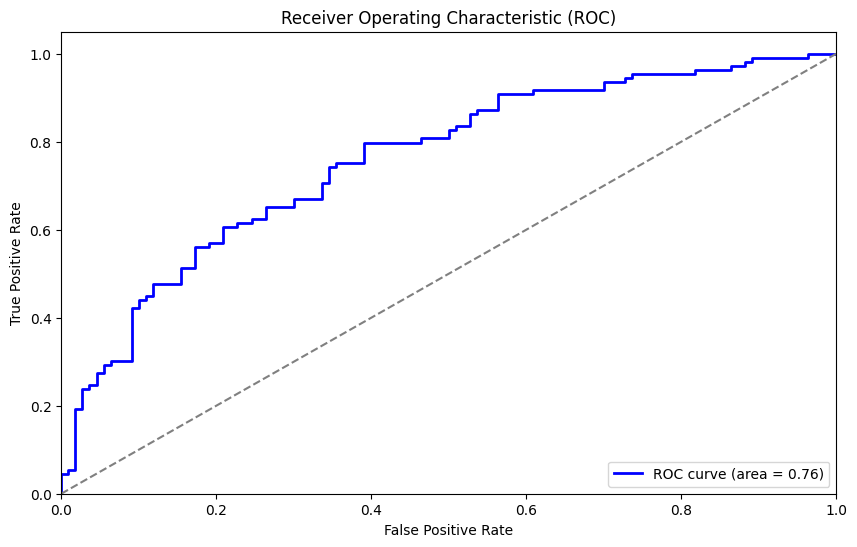


Optimal Threshold: 0.42


In [ ]:
threshold_gb, y_prob_gb  = plot_roc_curve(best_gb_model, new_x_test, new_y_test)

In [ ]:
y_pred_gb = (y_prob_gb >= threshold_gb).astype(int)

print(classification_report(new_y_test, y_pred_gb))

print(confusion_matrix(new_y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.75      0.61      0.67       110
           1       0.67      0.80      0.73       109

    accuracy                           0.70       219
   macro avg       0.71      0.70      0.70       219
weighted avg       0.71      0.70      0.70       219

[[67 43]
 [22 87]]


## Comparison with Random Forest

The Random Forest model had a mean cross-validation score of 0.6696. Let's compare this with the Gradient Boosting model's performance.

**Accuracy:**

Random Forest: 0.6696 (mean cross-validation score)
Gradient Boosting: 0.70 (after ROC optimization)
Observation: Gradient Boosting results are better in accuracy, especially after the ROC curve was used to find an optimal threshold.

**Precision and Recall:**

* Healthy:
Precision improved from 0.69 to 0.75 after ROC optimization in Gradient Boosting.
Recall decreased from 0.65 to 0.61 after ROC optimization.
* Not-healthy:
Precision decreased from 0.67 to 0.67, while Recall increased from 0.71 to 0.80 after optimization.
* Observation: While the precision for healthy improved, the recall dropped slightly. For Class not-healthy (1), the model recived higher recall but at the cost of a reduction in precision.

**Confusion Matrix**

The initial confusion matrix for Gradient Boosting showed that 72 true negatives and 77 true positives were correctly identified, with 38 false positives and 32 false negatives.
Post-ROC optimization, the model improved its ability to identify true positives (87) and true negatives (67), reducing false negatives to 22 but increasing false positives to 43.

* Observation: The optimized Gradient Boosting model made a trade-off by increasing the false positive rate to identify more true positives, which may be beneficial.

**Conclusion:**

Gradient Boosting generally performs better than Random Forest in this scenario, especially after ROC curve optimization, which improved the model's overall accuracy and its ability to correctly identify positive cases (not-healthy).